In [1]:
!pip install pytorch_lightning
!pip install datasets
from config_file import get_config

cfg = get_config()
cfg['batch_size'] = 128
cfg['preload'] = None
cfg['num_epochs'] = 20

from dataset import BilingualDataModule
from model import build_transformer
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, ModelSummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 56.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00


In [2]:
datamodule = BilingualDataModule(cfg)
datamodule.setup()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.73M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Max length of source sentences: 43
Max length of target sentences: 38


In [3]:
model = build_transformer(
    datamodule.tokenizer_src.get_vocab_size(),
    datamodule.tokenizer_tgt.get_vocab_size(),
    cfg["seq_len"],
    cfg["seq_len"],
    d_model=cfg["d_model"],

)

In [4]:
trainer = pl.Trainer(
    max_epochs=cfg["num_epochs"],
    accelerator="cuda",
    callbacks=[
        ModelCheckpoint(dirpath=cfg['model_folder'], verbose=True,),
        LearningRateMonitor(logging_interval='step', log_momentum=True),
        ModelSummary(max_depth=0)
    ],
    default_root_dir="Store/",
    fast_dev_run=False,
    check_val_every_n_epoch=2,
    num_sanity_val_steps=10,
    limit_val_batches=1000,
    precision="16-mixed",
    gradient_clip_val=0.5,
    detect_anomaly=False
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [5]:
from pytorch_lightning.tuner import Tuner

tuner = Tuner(trainer=trainer)
lr_finder = tuner.lr_find(model,datamodule=datamodule, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Max length of source sentences: 43
Max length of target sentences: 38


Finding best initial lr:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=20` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.01584893192461114
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at Store/.lr_find_a39ca3e4-dfdb-42e3-8542-21df2199ffac.ckpt


EPOCH: 0, Loss: nan


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at Store/.lr_find_a39ca3e4-dfdb-42e3-8542-21df2199ffac.ckpt


new_lr=0.01584893192461114


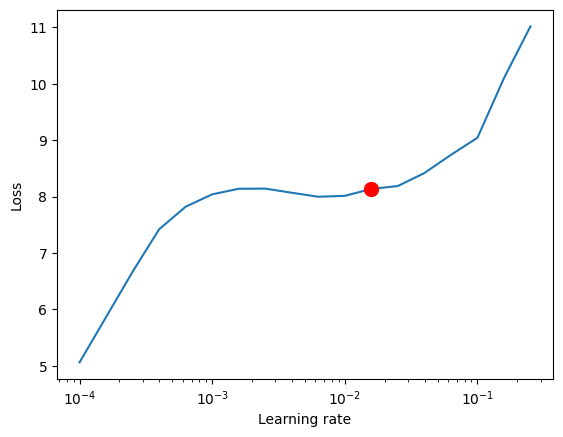

In [6]:
fig = lr_finder.plot(suggest=True)
fig.show()
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")


In [7]:
new_lr=0.00199526231496888
model.best_lr = new_lr

In [8]:
trainer.fit(model, datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Max length of source sentences: 43
Max length of target sentences: 38


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: By the fire stood a little fellow of three years old, in plaid frock and trousers.
TARGET: Andammo nel parlatorio, accanto al fuoco, ove c'era un bimbo vestito da scozzese.
PREDICTED: idra idra idra idra titolo impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile impalpabile visitatrice visitatrice visitatrice presi impalpabile impalpabile impalpabil

Training: |          | 0/? [00:00<?, ?it/s]

EPOCH: 0, Loss: 7.518711090087891


Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: "Now and then?"
TARGET: — Qualche volta.
PREDICTED: — E ?
--------------------------------------------------------------------------------
SOURCE: 'Well, if you want to so much, I will inquire about her first and will speak to her myself,' answered her mother. 'What do you see particular in her?
TARGET: — Se lo desideri tanto, prenderò informazioni sul suo conto, e l’avvicinerò io stessa — rispose la madre. — Cosa ci trovi di particolare?
PREDICTED: — Non è un ' è fatto che è un ’ ic , — disse Alice .
--------------------------------------------------------------------------------
SOURCE: It would be fine to go for a walk now.
TARGET: Adesso è bellissimo passeggiare.
PREDICTED: E la sua vita .
--------------------------------------------------------------------------------
SOURCE: 'He has seen him.
TARGET: — L’ha ricevuto.
PREDICTED: — Non è un ’ ic .
EPOCH: 1, CER: 0.7487477660179138, WER: 1.04972

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: An event even occurred of great importance to them both in this respect, namely, Kitty's meeting with Vronsky.
TARGET: A proposito di questo, accadde un avvenimento molto importante per tutti e due, l’incontro cioè di Kitty con Vronskij.
PREDICTED: Il viso era un ’ espressione di Vronskij , e , si alzò a Vronskij , e , e , e , e si avvicinò .
--------------------------------------------------------------------------------
SOURCE: "Yes; but the time is of no consequence: what followed is the strange point.
TARGET: — Sì, ma poco importa il giorno.
PREDICTED: — Sì , è un po ’ di .
--------------------------------------------------------------------------------
SOURCE: With infinite difficulty, for he was stubborn as a stone, I persuaded him to make an exchange in favour of a sober black satin and pearl-grey silk.
TARGET: Dopo molto discutere, perché era inflessibile come un masso, si decise a prendere

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: "What! you _will_ go?"
TARGET: — Come! Ve ne andate?
PREDICTED: — Che cosa volete ?
--------------------------------------------------------------------------------
SOURCE: But methylated spirit is more wholesome when taken into the system in large quantities than paraffine oil.
TARGET: Ma lo spirito denaturato è più sano del petrolio, se penetra nell’organismo in grande quantità.
PREDICTED: Ma è stato così che la verità , e la verità , è così così così .
--------------------------------------------------------------------------------
SOURCE: I know your forest.
TARGET: Conosco il tuo bosco.
PREDICTED: — Sì , io lo so .
--------------------------------------------------------------------------------
SOURCE: It was worth while going a little hungry.
TARGET: Vale la pena di soffrire un po’ la fame.
PREDICTED: Era una volta molto forte , ma la verità .
EPOCH: 5, CER: 1.0585201978683472, WER: 1.5878994

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: 'The day after to-morrow, I believe,' replied Vronsky.
TARGET: — Sembra domani l’altro — disse Vronskij.
PREDICTED: — — disse Stepan Arkad ’ ic , arrossendo .
--------------------------------------------------------------------------------
SOURCE: Levin sat down for a while and listened, but remembering all the conversations he had that day heard, he suddenly felt terribly bored.
TARGET: Levin rimase un po’ a sedere, ad ascoltare, ma ricordando tutti i discorsi della mattina, gli venne a un tratto una malinconia terribile.
PREDICTED: Levin si voltò e , Levin si voltò e , senza dubbio , ma si alzò e , e si fermò .
--------------------------------------------------------------------------------
SOURCE: The baby got hold in the wrong place and was angry.
TARGET: Il bambino non afferrava quello che doveva e si arrabbiava.
PREDICTED: La signora Fairfax era un ’ altra serata .
---------------------------

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: 'Playing "secretary"?' said the old Prince approaching them. 'Come now, we must be going, if you mean to come to the theatre.'
TARGET: — Giocate al secrétaire? — disse il vecchio principe accostandosi. — Su, però, andiamo, se vuoi arrivare in tempo a teatro.
PREDICTED: — , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,
--------------------------------------------------------------------------------
SOURCE: "You would often see him?
TARGET: — Lo vedevate spesso?
PREDICTED: — Oh ! — disse .
--------------------------------------------------------------------------------
SOURCE: It's a live business, anyway.

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: There were three men in sight, one of whom was a policeman; a market-cart full of cabbages, and a dilapidated looking cab.
TARGET: Passavano tre persone, una delle quali era una guardia; un carro colmo di cavoli e una vettura tutta sconquassata.
PREDICTED: La mattina dopo fu un aspetto , e un pelo liscio or ora , un .
--------------------------------------------------------------------------------
SOURCE: Well, and what are you doing?'
TARGET: Ebbene, cosa fai?
PREDICTED: Come siete ?
--------------------------------------------------------------------------------
SOURCE: 'Ah, this is magnanimity!' said Nicholas, and smiled. 'If you wish to be in the right, I can let you have that pleasure.
TARGET: — Ah, che magnanimità! — disse Nikolaj, e sorrise. — Se vuoi aver ragione, posso farti questo favore.
PREDICTED: — Ah , ti prego , ti prego , fammi fare la mia opinione e ti — disse .
-------------------

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: He looked at people as if they were inanimate things.
TARGET: Guardava agli uomini come a cose.
PREDICTED: Egli la guardò con un attimo , senza dir quello che si fosse ormai .
--------------------------------------------------------------------------------
SOURCE: Twice he routed up George and myself to see if we were lying on his trousers.
TARGET: Due volte scosse Giorgio e me, per veder se per caso non giacessimo sui suoi calzoni.
PREDICTED: , e , rientrata , , e , e , e , si .
--------------------------------------------------------------------------------
SOURCE: 'You see, you don't even know the word!
TARGET: — Ecco, non conosci neppure questa parola.
PREDICTED: — Tu non ami , non ti .
--------------------------------------------------------------------------------
SOURCE: Betsy waved her handkerchief to him.
TARGET: Betsy gli faceva cenno col fazzoletto.
PREDICTED: Vronskij si mise a ridere .

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: His life was quite swallowed up in a consciousness of suffering and a desire to be released from it.
TARGET: Tutta la sua vita si fondeva in un solo senso di pena e nel desiderio di liberarsene.
PREDICTED: Era una di quelle infinite considerazioni giuste che si di quelle crudeltà .
--------------------------------------------------------------------------------
SOURCE: Kitty was not in the bed beside him.
TARGET: Kitty non era nel letto accanto a lui.
PREDICTED: Kitty non rispose nulla .
--------------------------------------------------------------------------------
SOURCE: "I don't care about being married."
TARGET: — Non desidero maritarmi.
PREDICTED: — Non posso rispondervi su questo .
--------------------------------------------------------------------------------
SOURCE: "I am near nineteen: but I am not married. No."
TARGET: — Ne ho quasi diciannove, ma non sono maritata, no.
PREDICTED: — No

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: 'Honesty is only a negative quality,' said he.
TARGET: — L’onesta è soltanto una qualità negativa — disse.
PREDICTED: — È un uomo , è un uomo — disse la Lepre di Marzo .
--------------------------------------------------------------------------------
SOURCE: Jane, you must be reasonable, or in truth I shall again become frantic."
TARGET: Jane, siate ragionevole, o in verità mi fate diventar matto.
PREDICTED: Jane , vi esaminerò da voi .
--------------------------------------------------------------------------------
SOURCE: Don't be all day about it!' and he went on in these words:
TARGET: E così la Falsa-testuggine continuò:
PREDICTED: Non si può estirpare , e non ci nulla di nuovo .
--------------------------------------------------------------------------------
SOURCE: Are you afraid now in daylight?"
TARGET: Avete paura anche di giorno?
PREDICTED: Vi siete stata da voi ?
EPOCH: 17, CER: 0.84396

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: And for the rest, though you have a man's vigorous brain, you have a woman's heart and--it would not do."
TARGET: Del resto, benché abbiate il cervello vigoroso dell'uomo, avete il cuore debole della donna e sarebbe impossibile.
PREDICTED: E , per quanto tempo , non si può credere come se non fosse una volta , e non .
--------------------------------------------------------------------------------
SOURCE: If I was a co-operative stores and family hotel combined, I might be able to oblige you.
TARGET: Se fossi un magazzino cooperativo o un ristorante per famiglie, sarei in grado di servirvi.
PREDICTED: Io ho riflettuto un po ’ da voi e voglio dare un paio di .
--------------------------------------------------------------------------------
SOURCE: But in her dreams, when she had no control over her thoughts, her position appeared to her in all its shocking nakedness.
TARGET: Nel sonno, invece, quand

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


EPOCH: 19, Loss: 3.190670967102051
